In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
os.listdir('./data/house_price_adv')

['train.csv', 'test.csv']

In [2]:
train = pd.read_csv('./data/house_price_adv/train.csv')
print(train.shape)

(1460, 81)


In [3]:
house = train.copy() #copy
train.head()#original data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('all features type \n', house.dtypes.value_counts())

all features type 
 object     43
int64      35
float64     3
dtype: int64


In [5]:
isnull_series = house.isnull().sum().sort_values(ascending = False)
isnull_series[isnull_series > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

# target distribution

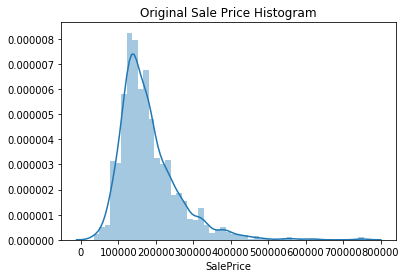

In [6]:
plt.title('Original Sale Price Histogram')
sns.distplot(house.SalePrice)

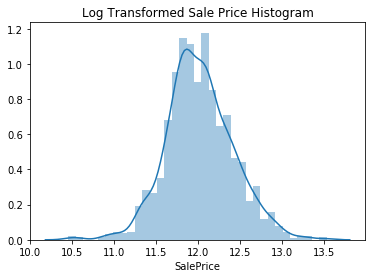

In [7]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house['SalePrice'])
sns.distplot(log_SalePrice)

In [8]:
house['SalePrice'] = np.log1p(house['SalePrice'])

# NA
- 전체 데이터 1480개 중 NA가 1000개 이상인 column은 drop
- 나머지는 평균으로 대체
- Object column은 one-hot encoding 처리하여, NA역시 하나의 값으로

In [9]:
house.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1, inplace = True)

house.fillna(house.mean(), inplace=True)

In [10]:
#NA가 있는 column들은 모두 object type
isnull_series = house.isnull().sum().sort_values(ascending = False)
house[isnull_series[isnull_series>0].index].dtypes

GarageType      object
GarageFinish    object
GarageCond      object
GarageQual      object
BsmtFinType2    object
BsmtExposure    object
BsmtFinType1    object
BsmtCond        object
BsmtQual        object
MasVnrType      object
Electrical      object
dtype: object

In [11]:
house_one_hot = pd.get_dummies(house)
house_one_hot.shape

(1460, 271)

In [12]:
isnull_series = house_one_hot.isnull().sum().sort_values(ascending = False)
isnull_series[isnull_series>0]

Series([], dtype: int64)

In [13]:
from sklearn.metrics import mean_squared_error


def get_rmses(models) :
    
    rmses = []
    
    def get_rsme(model) :
        pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred))

        print(model.__class__.__name__, 'log transformed RMSE : ', np.round(rmse, 3))
        return rmse
    
    for model in models :
        rmse = get_rsme(model)
        rmses.append(rmse)
        
    return rmses

# linear regression

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

y_target = house_one_hot['SalePrice']#log
X_features = house_one_hot.drop('SalePrice',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

In [16]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
eln = ElasticNet()

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
eln.fit(X_train, y_train)

models = [lr,ridge,lasso,eln]
get_rmses(models)

LinearRegression log transformed RMSE :  0.132
Ridge log transformed RMSE :  0.128
Lasso log transformed RMSE :  0.176
ElasticNet log transformed RMSE :  0.171


[0.13189576579153853,
 0.12750846334053012,
 0.17628250556471403,
 0.17111817461562784]

## coefficient plots

In [17]:
def get_top_bottom_coef(model, n = 10) :
    
    coef = pd.Series(model.coef_, index = X_features.columns).sort_values(ascending = False)
    
    #top10, bottom10
    coef_high = coef.head(n)
    coef_low = coef.tail(n)
    
    return coef_high, coef_low

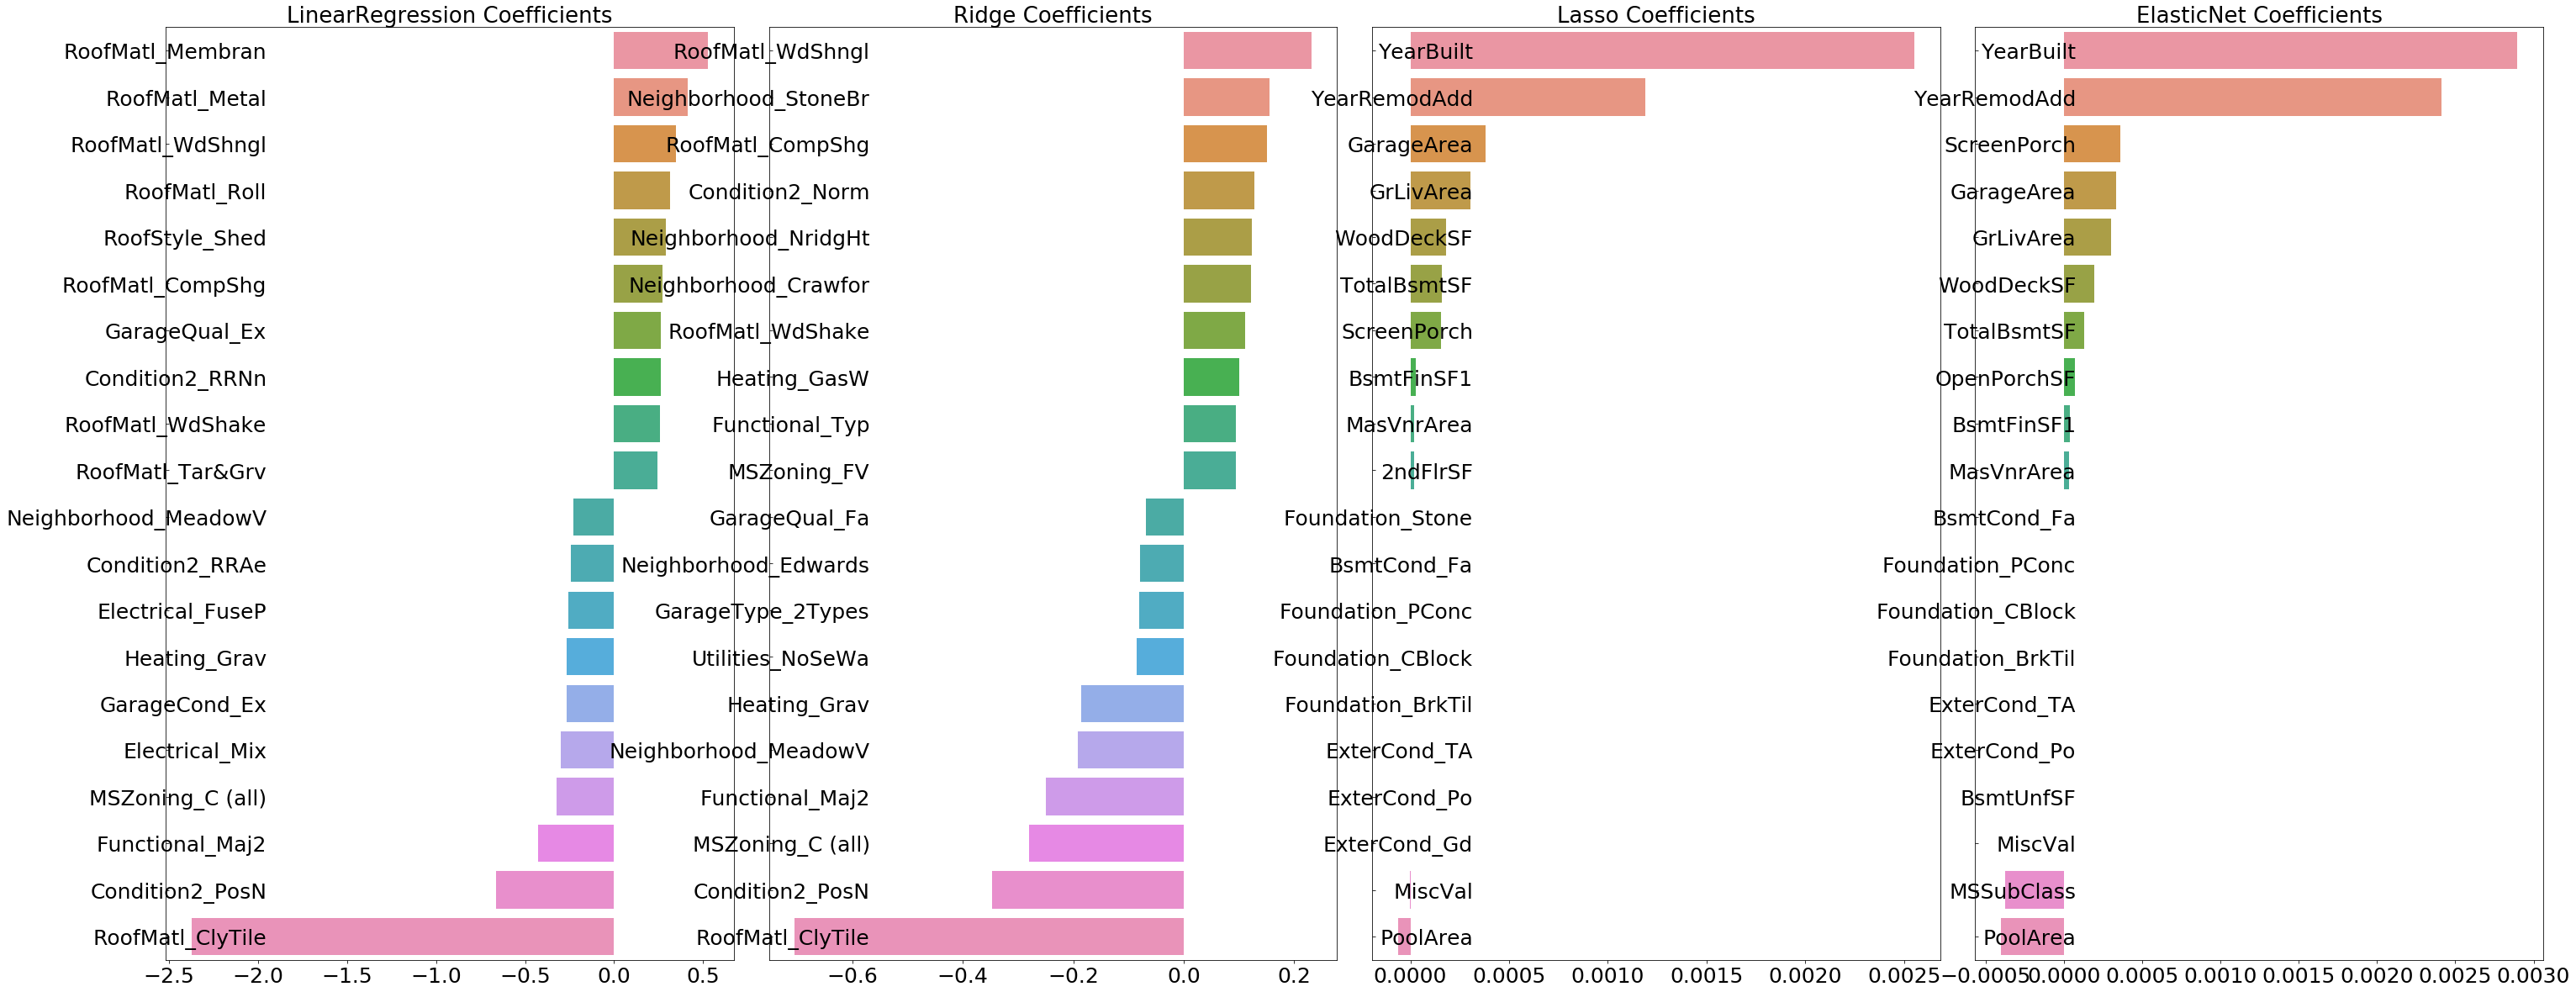

In [18]:
def visualize_coef(models) :
    
    fig, axs = plt.subplots(figsize = (40,16), nrows = 1, ncols = 4)
    fig.tight_layout()
    
    for i, model in enumerate(models) :
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i].set_title(model.__class__.__name__ + ' Coefficients', size = 26)
        axs[i].tick_params(axis = 'y', direction = 'in', pad = -120)
        
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()) :
            label.set_fontsize(25)
            
        sns.barplot(coef_concat.values, coef_concat.index, ax = axs[i])
        
models = [lr, ridge,lasso, eln]
visualize_coef(models)

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                            scoring = 'neg_mean_squared_error', cv = 5))
        
        rmse_avg = np.mean(rmse_list)
        
        print('{0} cv RMSE list : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} cv average RMSE : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        print('\n')

## CV K=5

In [20]:
get_avg_rmse_cv(models)

LinearRegression cv RMSE list : [0.135 0.165 0.168 0.111 0.198]
LinearRegression cv average RMSE : 0.155


Ridge cv RMSE list : [0.117 0.154 0.142 0.117 0.189]
Ridge cv average RMSE : 0.144


Lasso cv RMSE list : [0.161 0.204 0.177 0.181 0.265]
Lasso cv average RMSE : 0.198


ElasticNet cv RMSE list : [0.155 0.198 0.166 0.172 0.257]
ElasticNet cv average RMSE : 0.19




## hyperparmeter

In [21]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params) :
    grid_model = GridSearchCV(model, param_grid = params,
                             scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    
    print('{} 5 CV best average RMSE : {}, best alpha : {}'.format(model.__class__.__name__, np.round(rmse,4),
                                                                  grid_model.best_params_))

In [22]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
eln_params = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.0, 1.0, 0.1)}

In [23]:
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)
print_best_params(eln, eln_params)

Ridge 5 CV best average RMSE : 0.1418, best alpha : {'alpha': 12}
Lasso 5 CV best average RMSE : 0.142, best alpha : {'alpha': 0.001}
ElasticNet 5 CV best average RMSE : 0.1394, best alpha : {'alpha': 0.001, 'l1_ratio': 0.4}


In [24]:
ridge = Ridge(alpha = 12)
lasso = Lasso(alpha = 0.001)
eln = ElasticNet(l1_ratio = 0.4, alpha = 0.001)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
eln.fit(X_train, y_train)

models = [lr, ridge, lasso, eln]
get_rmses(models)

LinearRegression log transformed RMSE :  0.132
Ridge log transformed RMSE :  0.124
Lasso log transformed RMSE :  0.12
ElasticNet log transformed RMSE :  0.119


[0.13189576579153853,
 0.12387044279987379,
 0.11995999974065147,
 0.11880804730979326]

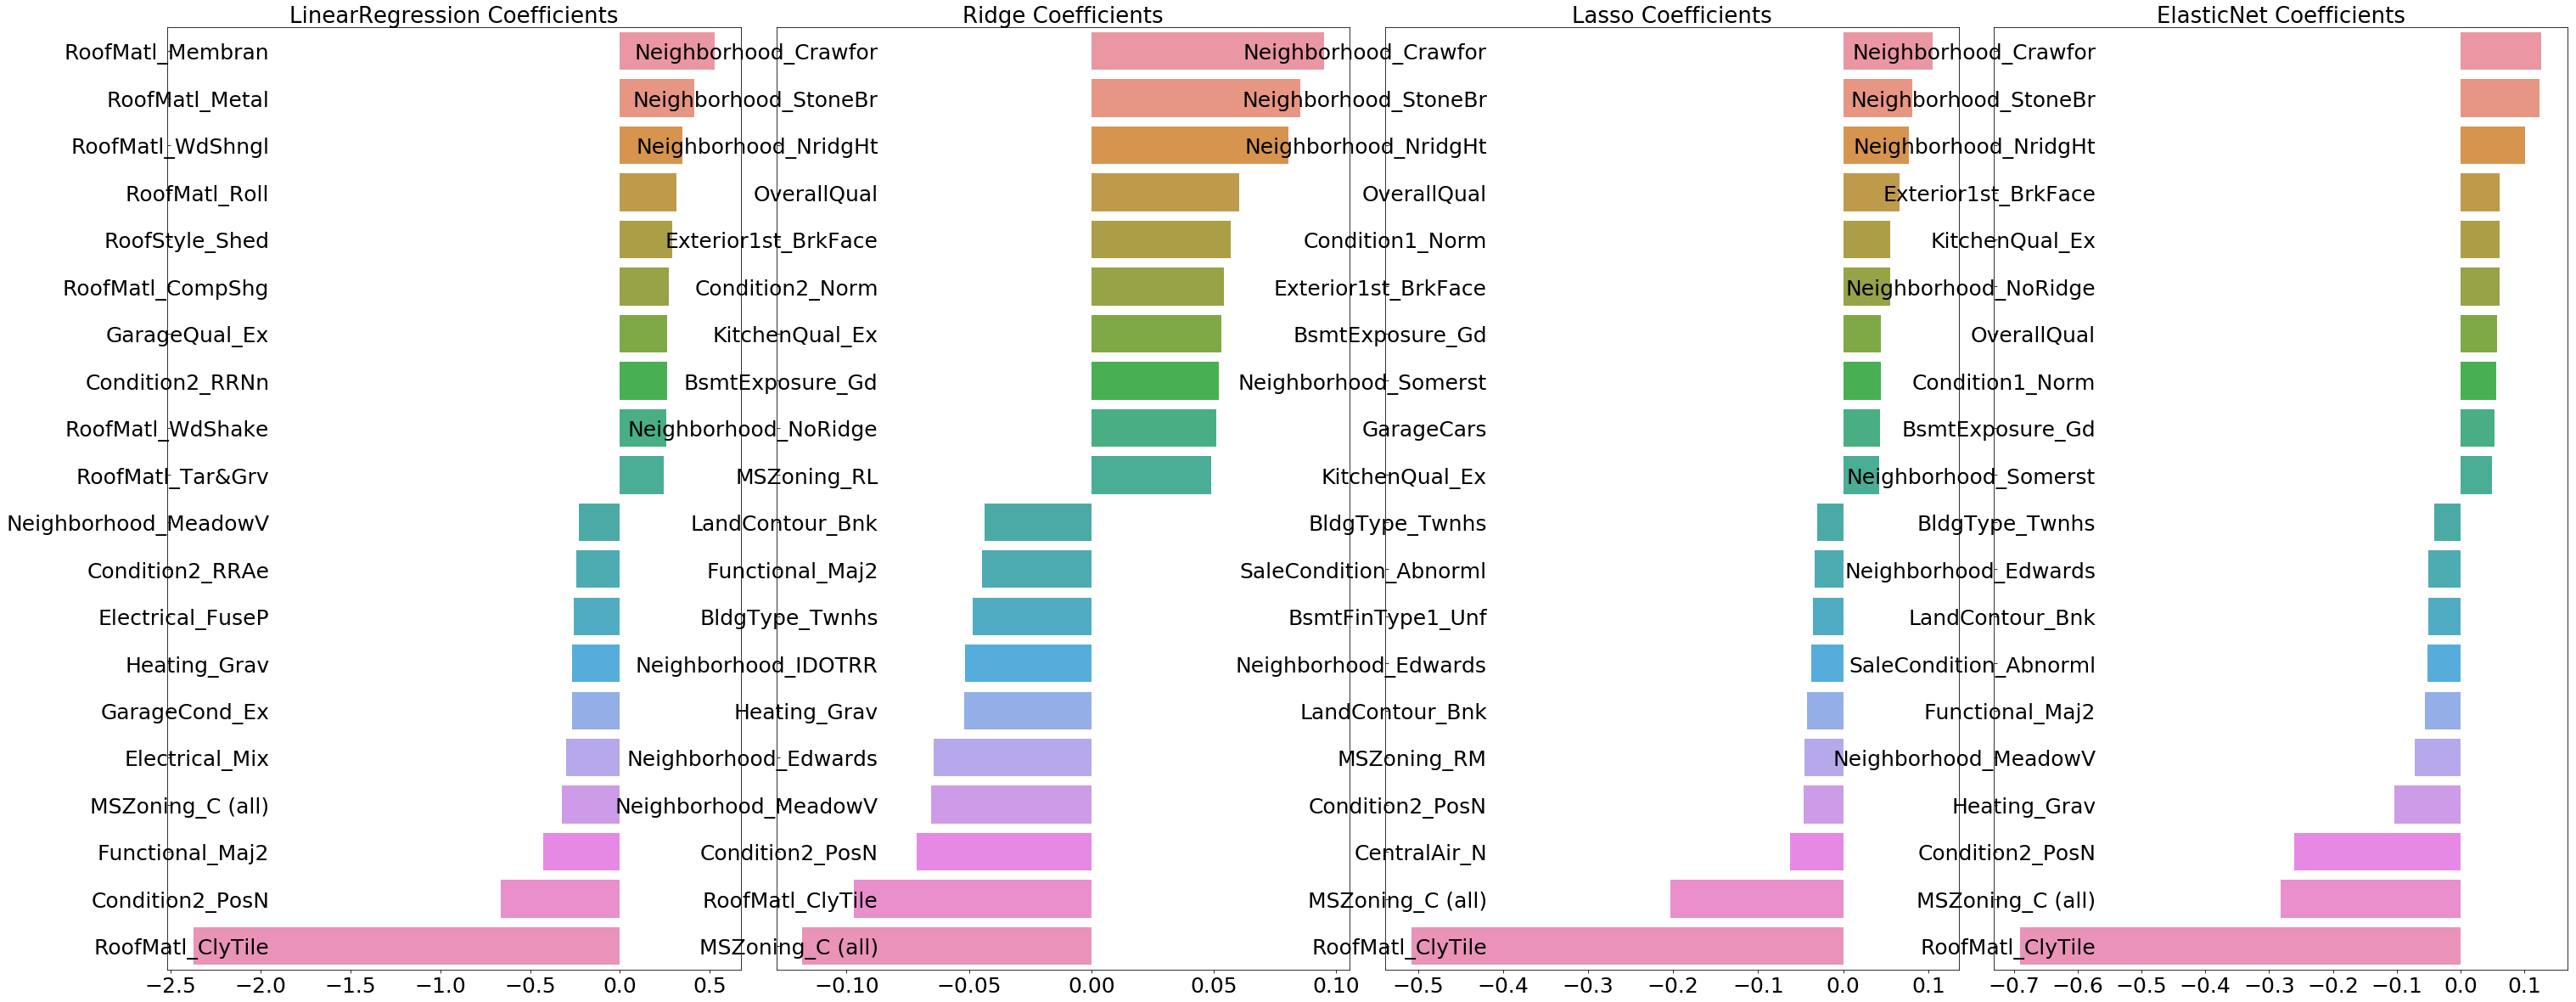

In [25]:
#better performance
visualize_coef(models)

lasso, elasticnet은 동일 칼럼이라도, 계수가 매우 작음

## skewness

$$skew() = \frac{3(mean - median)}{standard deviation}$$
![image](https://cdn-images-1.medium.com/max/1600/1*hxVvqttoCSkUT2_R1zA0Tg.gif)

- skew()함수의 값이 1이상이면 보통 왜곡이 높다고 판단.
- 1이상의 값을 반환하는 피처에 대해서 로그변환
- one-hot encoding된 피처들은 무시

In [26]:
from scipy.stats import skew

In [27]:
numeric_features = house.dtypes[house.dtypes != 'object'].index
skew_features = house[numeric_features].apply(lambda x : skew(x))

# skew > 1
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [28]:
house[skew_features_top.index] = np.log1p(house[skew_features_top.index])

In [29]:
house_one_hot = pd.get_dummies(house)
y_target = house_one_hot['SalePrice']
X_features = house_one_hot.drop('SalePrice', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

In [30]:
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)
print_best_params(eln, eln_params)

Ridge 5 CV best average RMSE : 0.1275, best alpha : {'alpha': 10}
Lasso 5 CV best average RMSE : 0.1252, best alpha : {'alpha': 0.001}
ElasticNet 5 CV best average RMSE : 0.1237, best alpha : {'alpha': 0.001, 'l1_ratio': 0.5}


In [31]:
#best parmeter
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 0.001)
eln = ElasticNet(l1_ratio = 0.5, alpha = 0.001)

lr.fit(X_train,y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
eln.fit(X_train, y_train)

models = [lr, ridge, lasso, eln]
get_rmses(models)

LinearRegression log transformed RMSE :  0.128
Ridge log transformed RMSE :  0.122
Lasso log transformed RMSE :  0.119
ElasticNet log transformed RMSE :  0.117


[0.12826037058748685,
 0.1224990814130163,
 0.11925534799989726,
 0.1174672468132853]

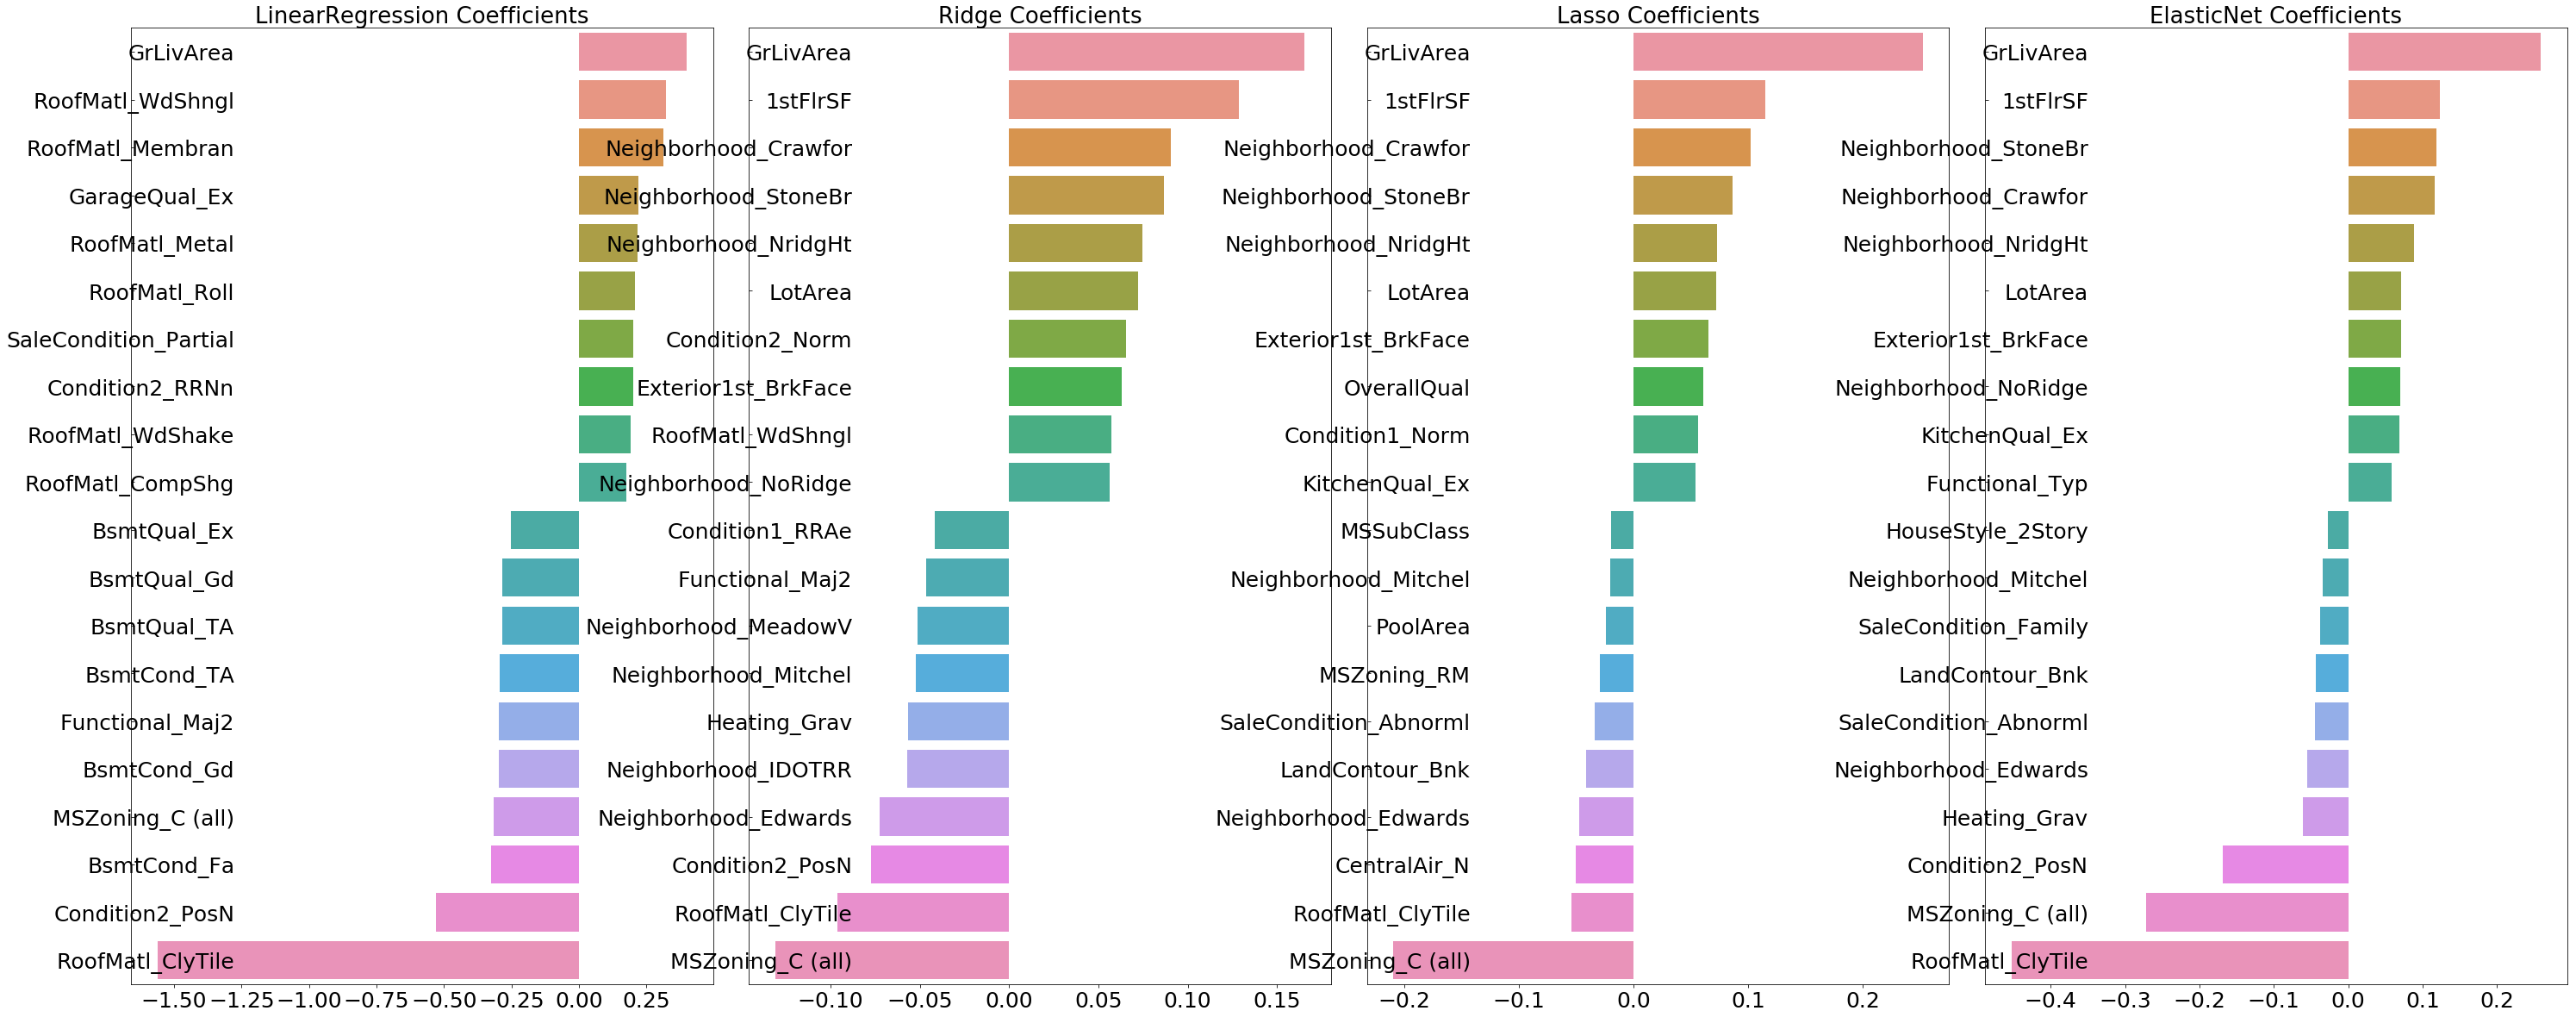

In [32]:
visualize_coef(models)

## outlier

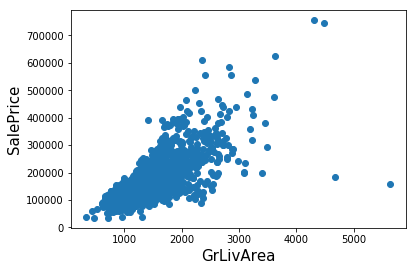

In [33]:
#계수가 가장 높게 나타난 변수를 살펴봄
plt.scatter(train.GrLivArea, train.SalePrice)
plt.ylabel('SalePrice', fontsize = 15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [34]:
cond1 = house_one_hot['GrLivArea'] > np.log1p(4000)
cond2 = house_one_hot['SalePrice'] < np.log1p(500000)

outlier_index = house_one_hot[cond1 & cond2].index
print('outlier record index : ', outlier_index.values)
print('before drop outliers shape : ', house_one_hot.shape)

house_one_hot.drop(outlier_index, axis = 0, inplace=True)
print('after drop outliers shape : ', house_one_hot.shape)

outlier record index :  [ 523 1298]
before drop outliers shape :  (1460, 271)
after drop outliers shape :  (1458, 271)


In [35]:
y_target = house_one_hot.SalePrice
X_features = house_one_hot.drop('SalePrice', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)
print_best_params(eln, eln_params)

Ridge 5 CV best average RMSE : 0.1125, best alpha : {'alpha': 8}
Lasso 5 CV best average RMSE : 0.1122, best alpha : {'alpha': 0.001}
ElasticNet 5 CV best average RMSE : 0.1101, best alpha : {'alpha': 0.001, 'l1_ratio': 0.4}


In [36]:
#best parmeter
ridge = Ridge(alpha = 8)
lasso = Lasso(alpha = 0.001)
eln = ElasticNet(l1_ratio = 0.4, alpha = 0.001)

lr.fit(X_train,y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
eln.fit(X_train, y_train)

models = [lr, ridge, lasso, eln]
get_rmses(models)

LinearRegression log transformed RMSE :  0.129
Ridge log transformed RMSE :  0.103
Lasso log transformed RMSE :  0.1
ElasticNet log transformed RMSE :  0.101


[0.12864941604870003,
 0.10345177546603239,
 0.1002417046089002,
 0.10104692413798577]

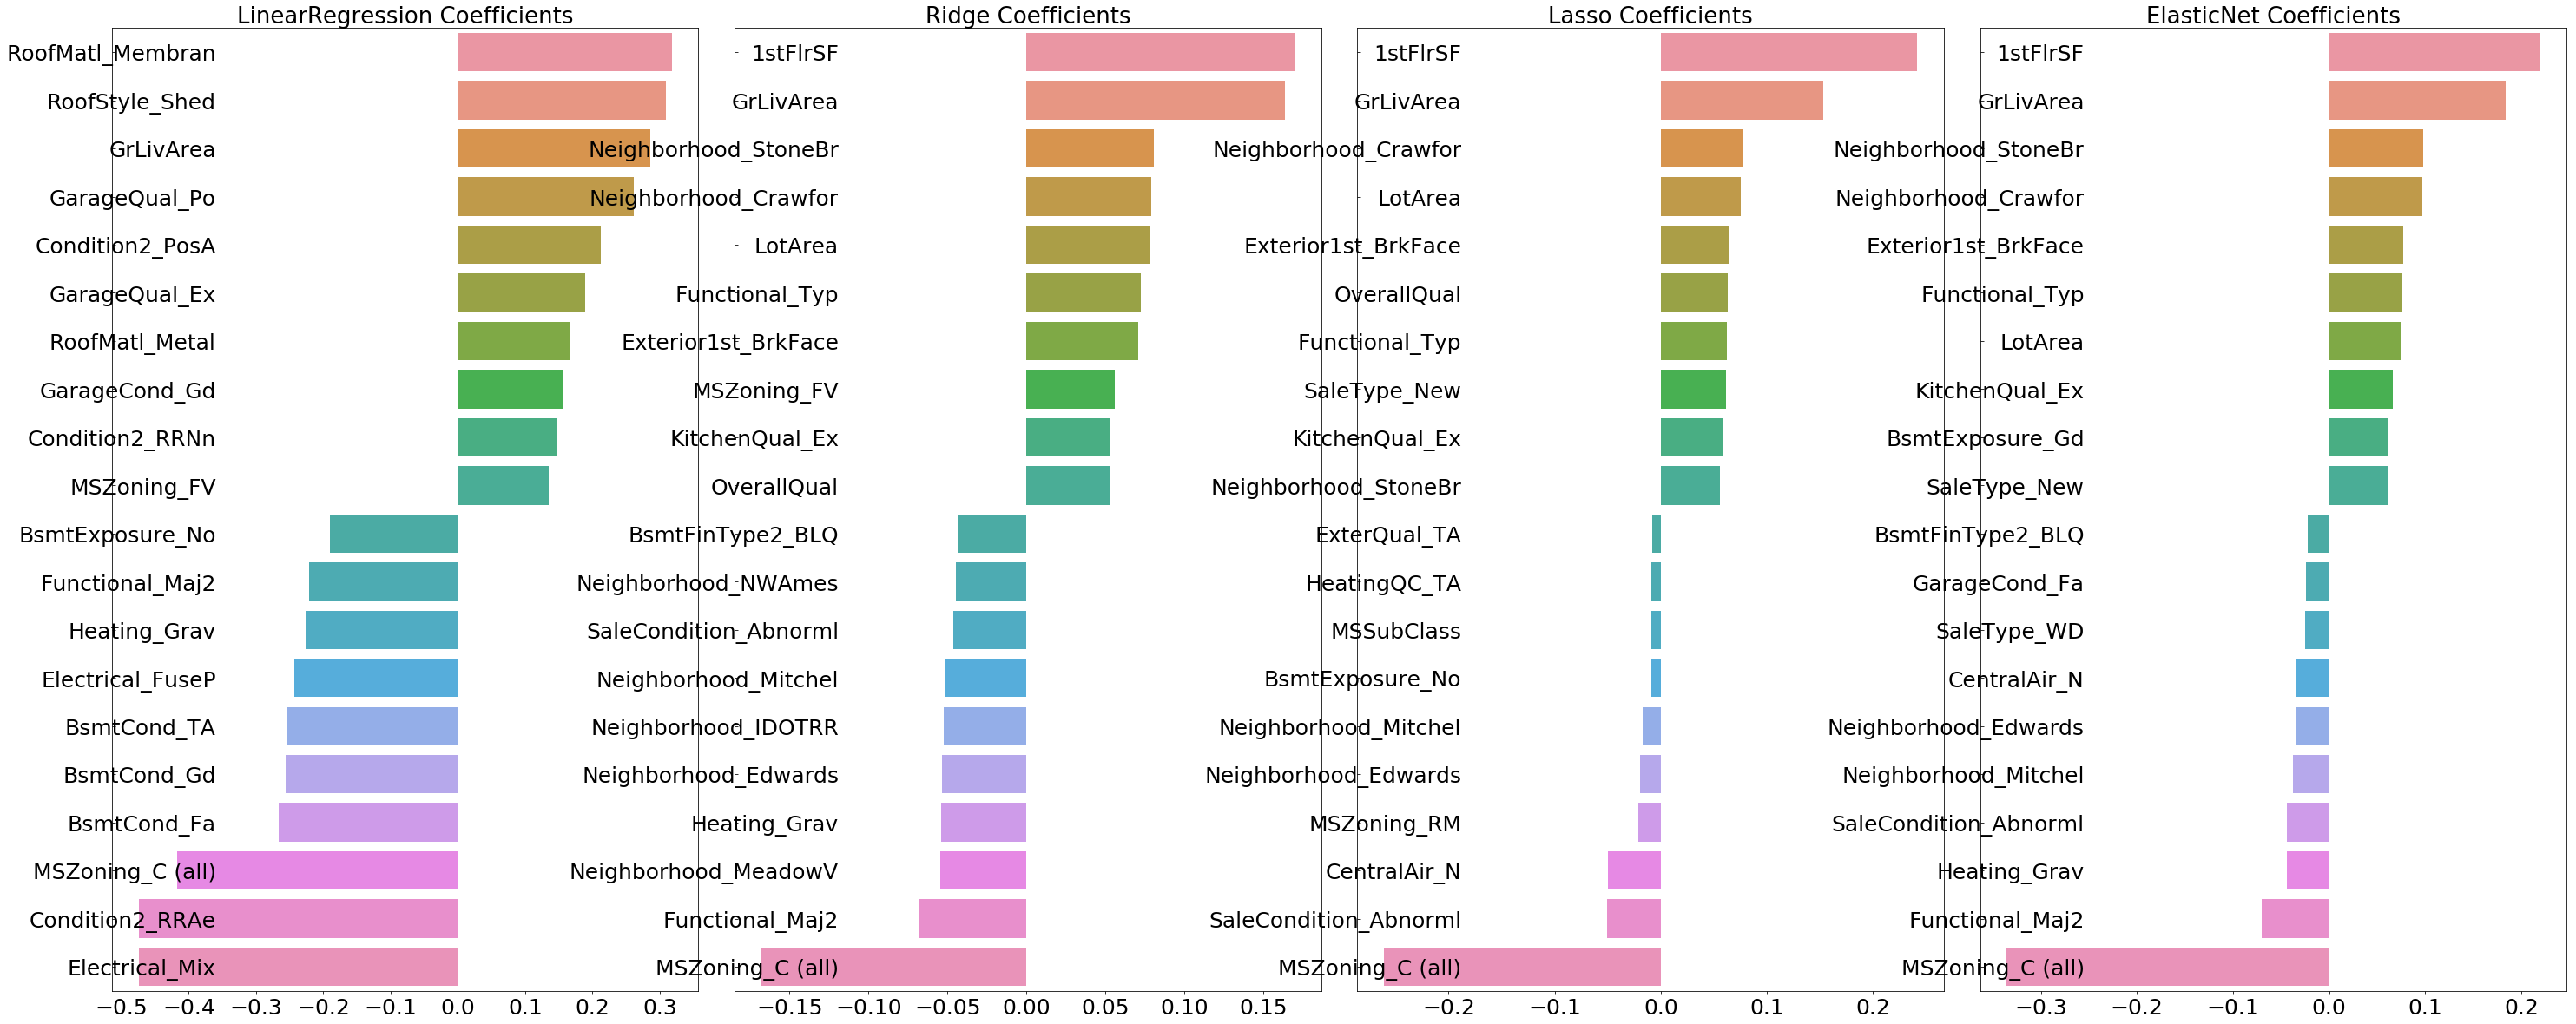

In [37]:
visualize_coef(models)

# tree models

In [62]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb = XGBRegressor(n_jobs = -1)
lgb = LGBMRegressor(n_jobs = -1)

xgb.fit(X_train,y_train)
lgb.fit(X_train, y_train)


models = [xgb, lgb]
get_rmses(models)

XGBRegressor log transformed RMSE :  0.11
LGBMRegressor log transformed RMSE :  0.114


[0.10984042109823909, 0.11373579333618505]

In [52]:
%time

xgb_params = {'n_estimators':[200,500,1000], 'learning_rate' : [0.001,0.01,0.1],
             'colsample_bytree' : [0.3,0.5,0.7], 'subsample' : [0.2,0.4,0.5,0.8]}

print_best_params(xgb, xgb_params)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs
XGBRegressor 5 CV best average RMSE : 0.1147, best alpha : {'subsample': 0.8, 'colsample_bytree': 0.3, 'n_estimators': 500, 'learning_rate': 0.1}


In [63]:
%time

lgb_params = {'n_estimators':[200,500,1000], 'learning_rate' : [0.001,0.01,0.05,0.1], 'num_leaves' : [2,4,8,10],
             'colsample_bytree' : [0.3,0.4,0.5], 'subsample' : [0.5,0.6,0.7], 'reg_lambda' : [5,10,15]}

print_best_params(lgb, lgb_params)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
LGBMRegressor 5 CV best average RMSE : 0.1161, best alpha : {'subsample': 0.5, 'colsample_bytree': 0.4, 'num_leaves': 4, 'learning_rate': 0.05, 'reg_lambda': 10, 'n_estimators': 1000}


## feature importnace

In [64]:
xgb = XGBRegressor(n_jobs = -1, subsample=0.8, colsample_bytree=0.3, n_estimators=500, learning_rate=0.1)
lgb = LGBMRegressor(n_jobs = -1, subsample=0.5, colsample_bytree=0.4, num_leaves=4, learning_rate=0.05,
                   reg_lambda=10, n_estimators=1000)

xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=4, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=10, silent=True,
       subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

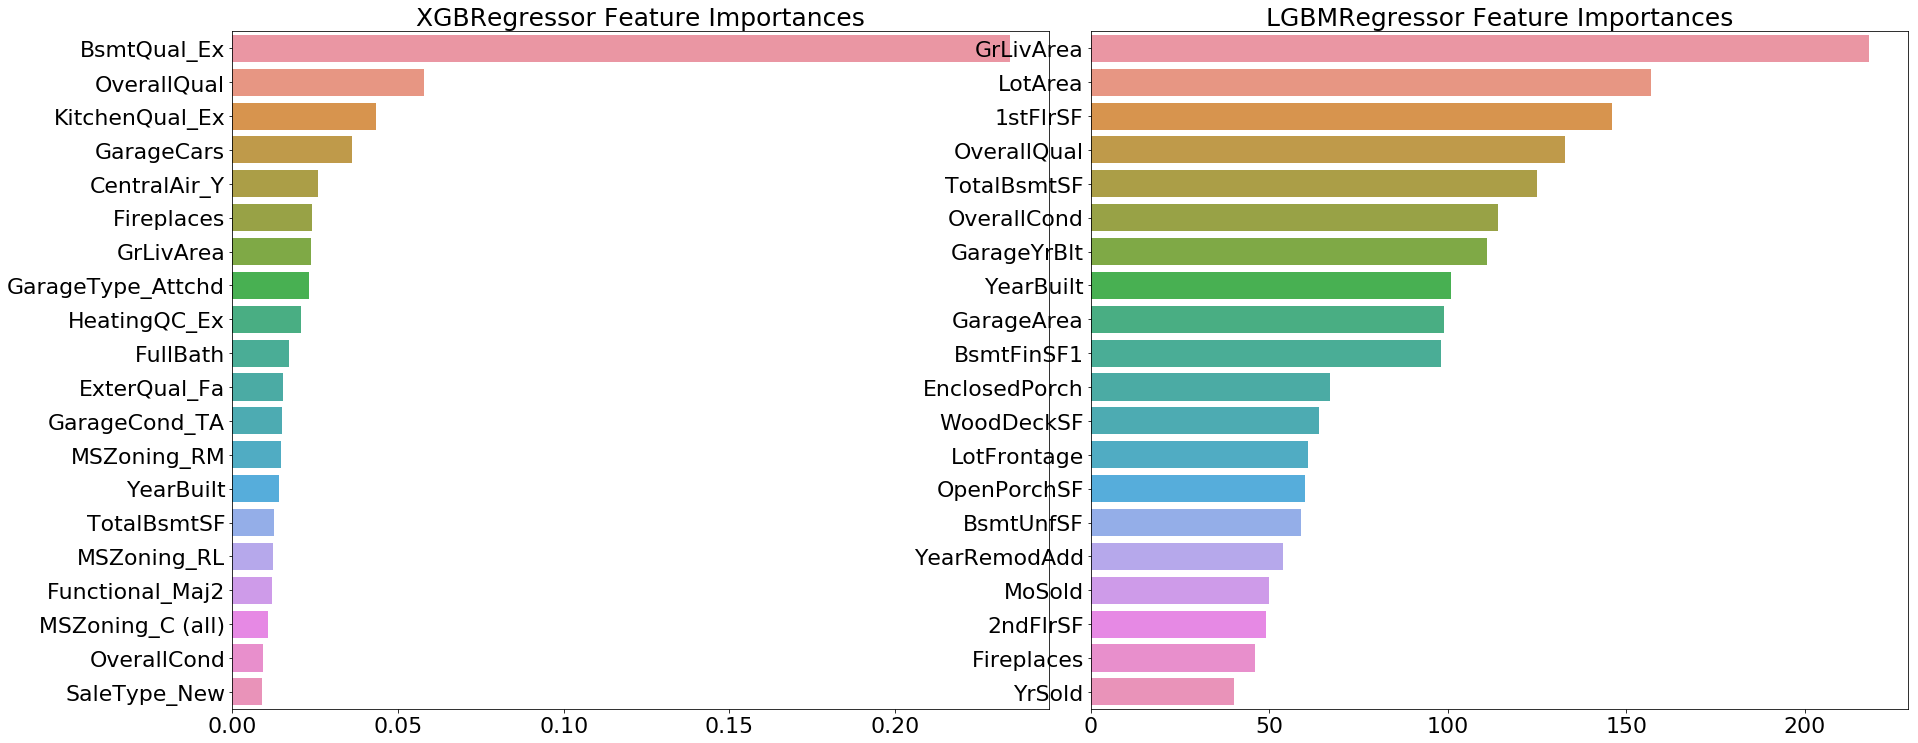

In [70]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [xgb, lgb]
visualize_ftr_importances(models)

# blending
## Ridge(0.4) + Lasso(0.6)

In [74]:
def get_rmse_pred(preds) :
    for key in preds.keys() :
        pred_value = preds[key]
        rmse = np.sqrt(mean_squared_error(y_test, pred_value))
        print('{} model RMSE : {}'.format(key, rmse))
        

In [75]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'final blend' : pred, 'Ridge' : ridge_pred, 'Lasso' : lasso_pred}

get_rmse_pred(preds)

Ridge model RMSE : 0.10345177546603239
Lasso model RMSE : 0.1002417046089002
final blend model RMSE : 0.10007930884470498


## Lasso(0.75) + ElasticNet(0.25)

In [76]:
eln.fit(X_train, y_train)
eln_pred = eln.predict(X_test)

In [83]:
pred = 0.75*lasso_pred + 0.25*eln_pred

preds = {'final blend' : pred, 'Lasso' : lasso_pred, 'ElasticNet' : eln_pred}

get_rmse_pred(preds)

ElasticNet model RMSE : 0.10104692413798577
Lasso model RMSE : 0.1002417046089002
final blend model RMSE : 0.09999359580903501


# XGB(0.2) + LGB(0.8)

In [85]:
xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
lgb_pred = lgb.predict(X_test)

In [94]:
pred = 0.2*xgb_pred + 0.8*lgb_pred

preds = {'final blend' : pred, 'XGBoost' : xgb_pred, 'LightGBM' : lgb_pred}

get_rmse_pred(preds)

LightGBM model RMSE : 0.1015065721553885
XGBoost model RMSE : 0.10947388419772826
final blend model RMSE : 0.10066762648597585


# stacking

In [95]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [111]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds) :
    
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model start! ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        
        print('\t 폴드 세트: ',folder_counter,' start ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        
        model.fit(X_tr , y_tr)       
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred , test_pred_mean

In [112]:
#dataframe -> numpy array
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [119]:
ridge_train, ridge_test = get_stacking_base_datasets(ridge, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso, X_train_n, y_train_n, X_test_n, 5)
eln_train, eln_test = get_stacking_base_datasets(eln, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_test_n, 5)
lgb_train, lgb_test = get_stacking_base_datasets(lgb, X_train_n, y_train_n, X_test_n, 5)

Ridge  model start! 
	 폴드 세트:  0  start 
	 폴드 세트:  1  start 
	 폴드 세트:  2  start 
	 폴드 세트:  3  start 
	 폴드 세트:  4  start 
Lasso  model start! 
	 폴드 세트:  0  start 
	 폴드 세트:  1  start 
	 폴드 세트:  2  start 
	 폴드 세트:  3  start 
	 폴드 세트:  4  start 
ElasticNet  model start! 
	 폴드 세트:  0  start 
	 폴드 세트:  1  start 
	 폴드 세트:  2  start 
	 폴드 세트:  3  start 
	 폴드 세트:  4  start 
XGBRegressor  model start! 
	 폴드 세트:  0  start 
	 폴드 세트:  1  start 
	 폴드 세트:  2  start 
	 폴드 세트:  3  start 
	 폴드 세트:  4  start 
LGBMRegressor  model start! 
	 폴드 세트:  0  start 
	 폴드 세트:  1  start 
	 폴드 세트:  2  start 
	 폴드 세트:  3  start 
	 폴드 세트:  4  start 


In [127]:
stack_final_X_train = np.concatenate([ridge_train, lasso_train, xgb_train, lgb_train, eln_train ], axis = 1)
stack_final_X_test = np.concatenate([ridge_test, lasso_test, xgb_test, lgb_test, eln_test], axis = 1)

In [128]:
meta_model = Lasso(alpha = 0.0005)
meta_model.fit(stack_final_X_train, y_train)
final_pred = meta_model.predict(stack_final_X_test)

rmse = np.sqrt(mean_squared_error(y_test, final_pred))
print('stacking final RMSE : ', rmse)

stacking final RMSE :  0.09745442942570347
